## Домашнее задание: Разработка рекомендательной системы для музыки на платформе Spotify

1. Предобработка данных и EDA

Необходимо провести анализ данных (Exploratory Data Analysis, EDA) для понимания структуры датасетов и подготовки данных к разработке рекомендательной системы: 
- Загрузка данных и очистка выбросов
- Рассчитайте основные статистики для числовых колонок: среднее, медиану, стандартное отклонение, минимумы и максимумы.
- Проведите корреляционный анализ между различными признаками (например, между valence, energy, danceability и другими признаками).
- Постройте гистограммы и коробочные диаграммы для визуализации распределений числовых признаков.
- Анализ категориальных данных
- Постройте тепловую карту корреляции между признаками.

2. Разработка рекомендательной системы (Контентная фильтрация)

В этой части задания необходимо разработать рекомендательную систему, которая будет основывать свои рекомендации на характеристиках самих песен.

- Построение модели на основе контента. Используйте признаки, чтобы рекомендовать похожие песни по жанрам и стилю.
- Проведите кластеризацию для улучшения рекомендация на основе признаков с использованием алгоритмов, таких как K-means или DBSCAN. Рекомендуйте песни, которые находятся в одном кластере с уже выбранной песней.

3. Построение гибридной модели

    Разработайте гибридную рекомендательную систему, которая сочетает контентную фильтрацию и методы кластеризации признаков. Таким образом, рекомендации могут быть основаны как на схожести признаков, так и на принадлежности песен к определённым группам (кластерам).

4. Оценка качества модели

После того как модели будут построены, необходимо провести их оценку.

- Придумайте метрику для оценки качества на тренировочных данных.
- Создайте свой валидационный набор в группе студентов. Каждому из студентов необходимо выбрать по 30 песен, которые ему нравятся. Желательно разных исполнителей. Объедините данные в группе и создайте единый набор.
- Оцените свою модель с помощью метрик precision/recall at K на разных параметрах и объясните полученный результат.
- Обязательным пунктом для сдачи дз является оценка качества на этой валидации по метрикам precision_at_k, recall_at_k при k = 10. 

In [18]:
import warnings
warnings.filterwarnings("ignore")

In [20]:
pip install yellowbrick

Note: you may need to restart the kernel to use updated packages.


In [22]:
import os
import numpy as np
import pandas as pd

import seaborn as sns
import plotly.express as px 
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import cdist
from collections import defaultdict
import difflib


In [104]:
#Зачитаемм данные
data = pd.read_csv("data/data.csv")
genre_data = pd.read_csv('data/data_by_genres.csv')
year_data = pd.read_csv('data/data_by_year.csv')
artist_data = pd.read_csv('data/data_by_artist.csv')

In [26]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           170653 non-null  float64
 1   year              170653 non-null  int64  
 2   acousticness      170653 non-null  float64
 3   artists           170653 non-null  object 
 4   danceability      170653 non-null  float64
 5   duration_ms       170653 non-null  int64  
 6   energy            170653 non-null  float64
 7   explicit          170653 non-null  int64  
 8   id                170653 non-null  object 
 9   instrumentalness  170653 non-null  float64
 10  key               170653 non-null  int64  
 11  liveness          170653 non-null  float64
 12  loudness          170653 non-null  float64
 13  mode              170653 non-null  int64  
 14  name              170653 non-null  object 
 15  popularity        170653 non-null  int64  
 16  release_date      17

In [28]:
print(genre_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2973 entries, 0 to 2972
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mode              2973 non-null   int64  
 1   genres            2973 non-null   object 
 2   acousticness      2973 non-null   float64
 3   danceability      2973 non-null   float64
 4   duration_ms       2973 non-null   float64
 5   energy            2973 non-null   float64
 6   instrumentalness  2973 non-null   float64
 7   liveness          2973 non-null   float64
 8   loudness          2973 non-null   float64
 9   speechiness       2973 non-null   float64
 10  tempo             2973 non-null   float64
 11  valence           2973 non-null   float64
 12  popularity        2973 non-null   float64
 13  key               2973 non-null   int64  
dtypes: float64(11), int64(2), object(1)
memory usage: 325.3+ KB
None


In [30]:
print(year_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mode              100 non-null    int64  
 1   year              100 non-null    int64  
 2   acousticness      100 non-null    float64
 3   danceability      100 non-null    float64
 4   duration_ms       100 non-null    float64
 5   energy            100 non-null    float64
 6   instrumentalness  100 non-null    float64
 7   liveness          100 non-null    float64
 8   loudness          100 non-null    float64
 9   speechiness       100 non-null    float64
 10  tempo             100 non-null    float64
 11  valence           100 non-null    float64
 12  popularity        100 non-null    float64
 13  key               100 non-null    int64  
dtypes: float64(11), int64(3)
memory usage: 11.1 KB
None


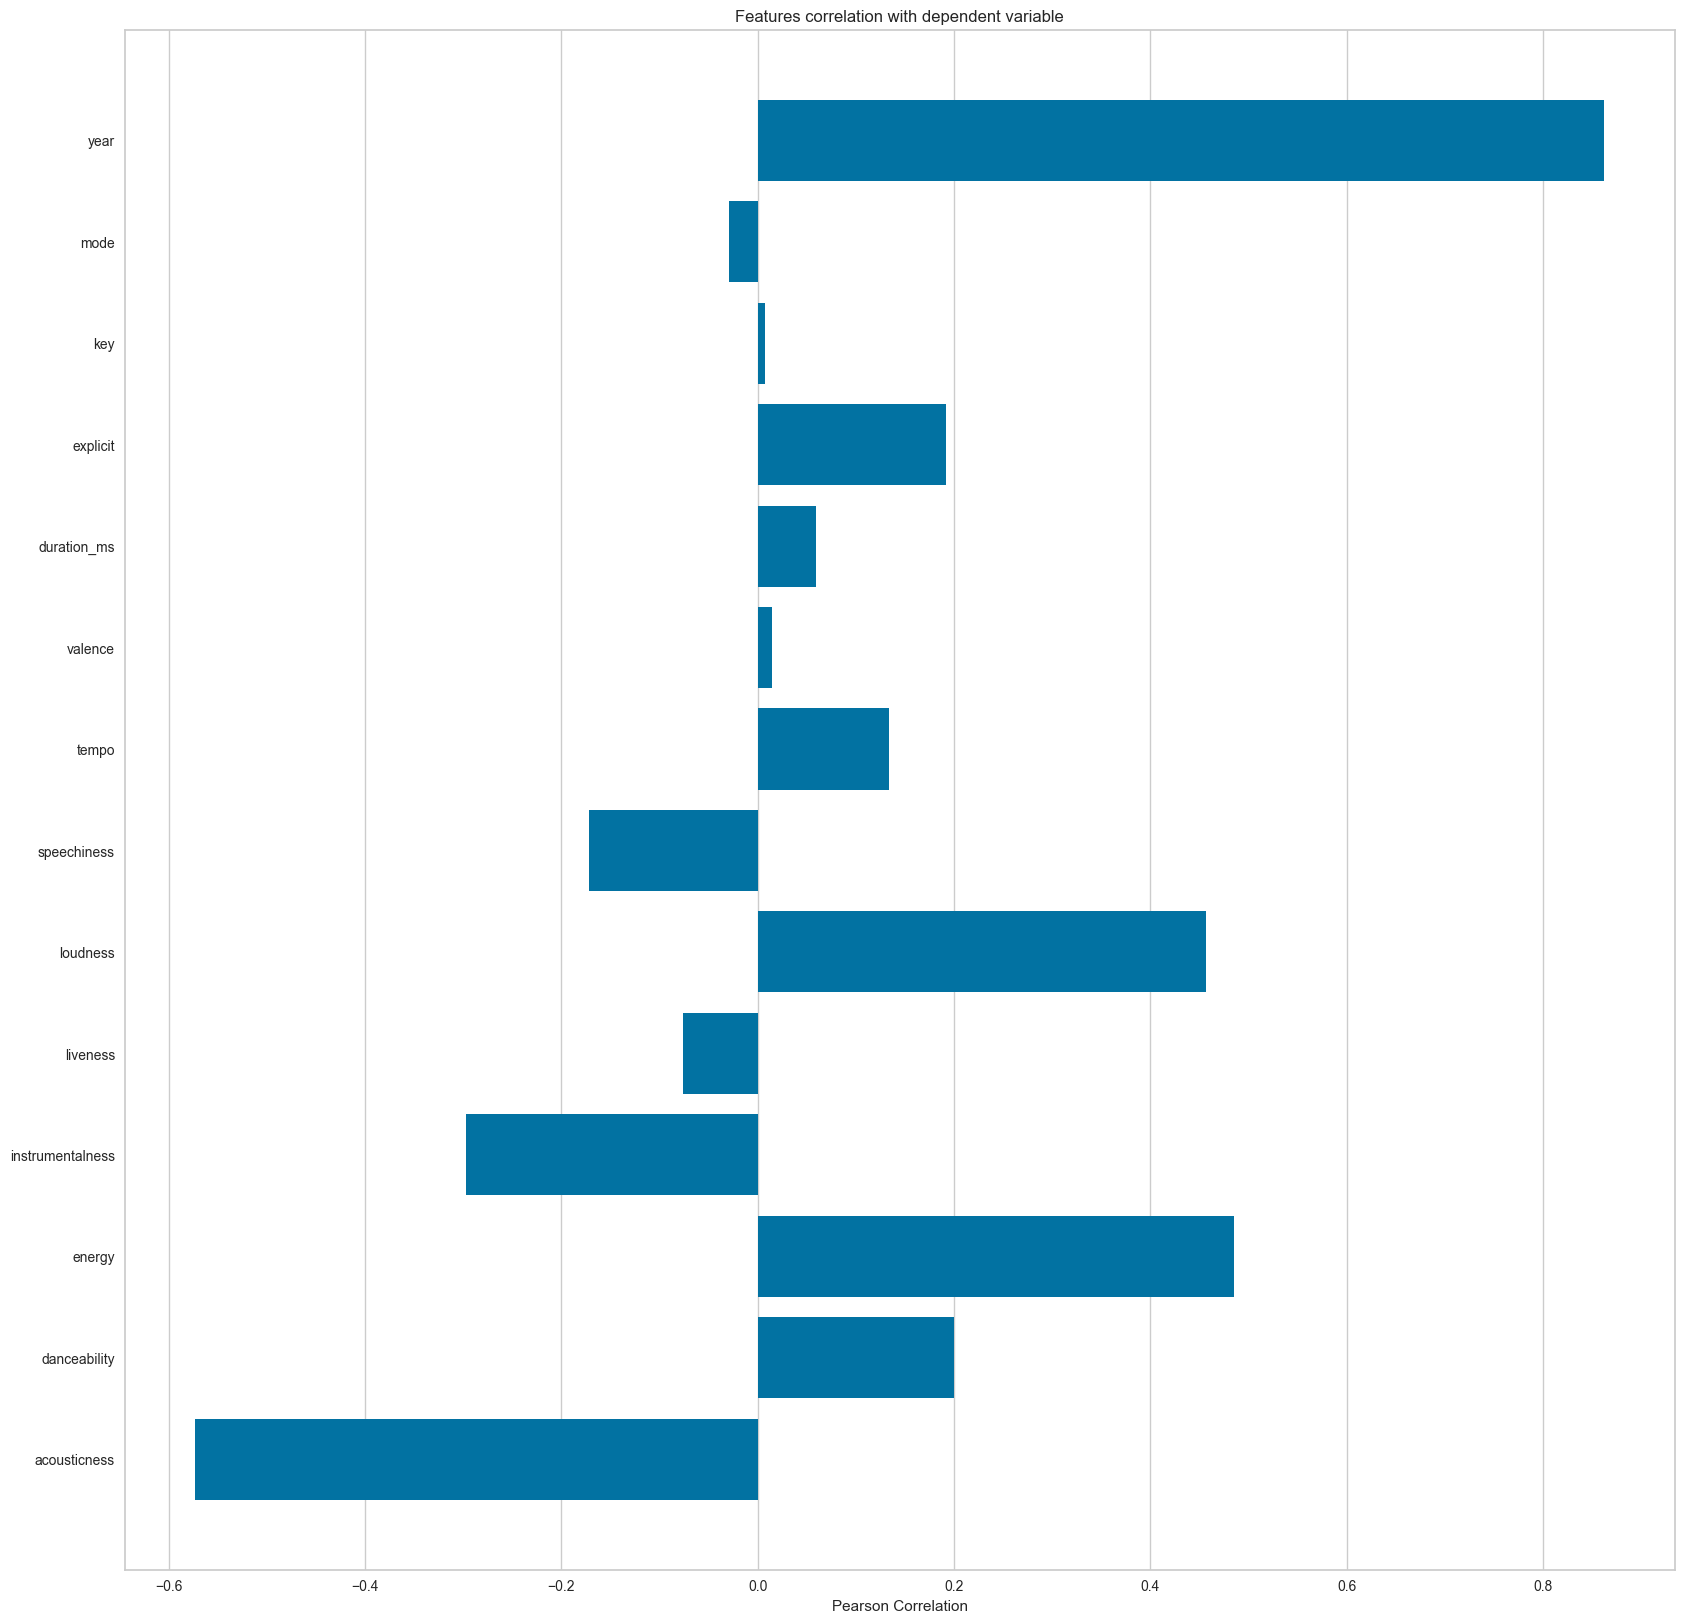

<Axes: title={'center': 'Features correlation with dependent variable'}, xlabel='Pearson Correlation'>

In [32]:
#проведем  анализ корреляции признаков
#Целевая переменная — популярность. Как другие признаки (например, жанр, длительность и т.п.) влияют на популярность песни.
from yellowbrick.target import FeatureCorrelation

feature_names = ['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo', 'valence','duration_ms','explicit','key','mode','year']

X, y = data[feature_names], data['popularity']

features = np.array(feature_names)

visualizer = FeatureCorrelation(labels=features)

plt.rcParams['figure.figsize']=(20,20)
visualizer.fit(X, y)   
visualizer.show()

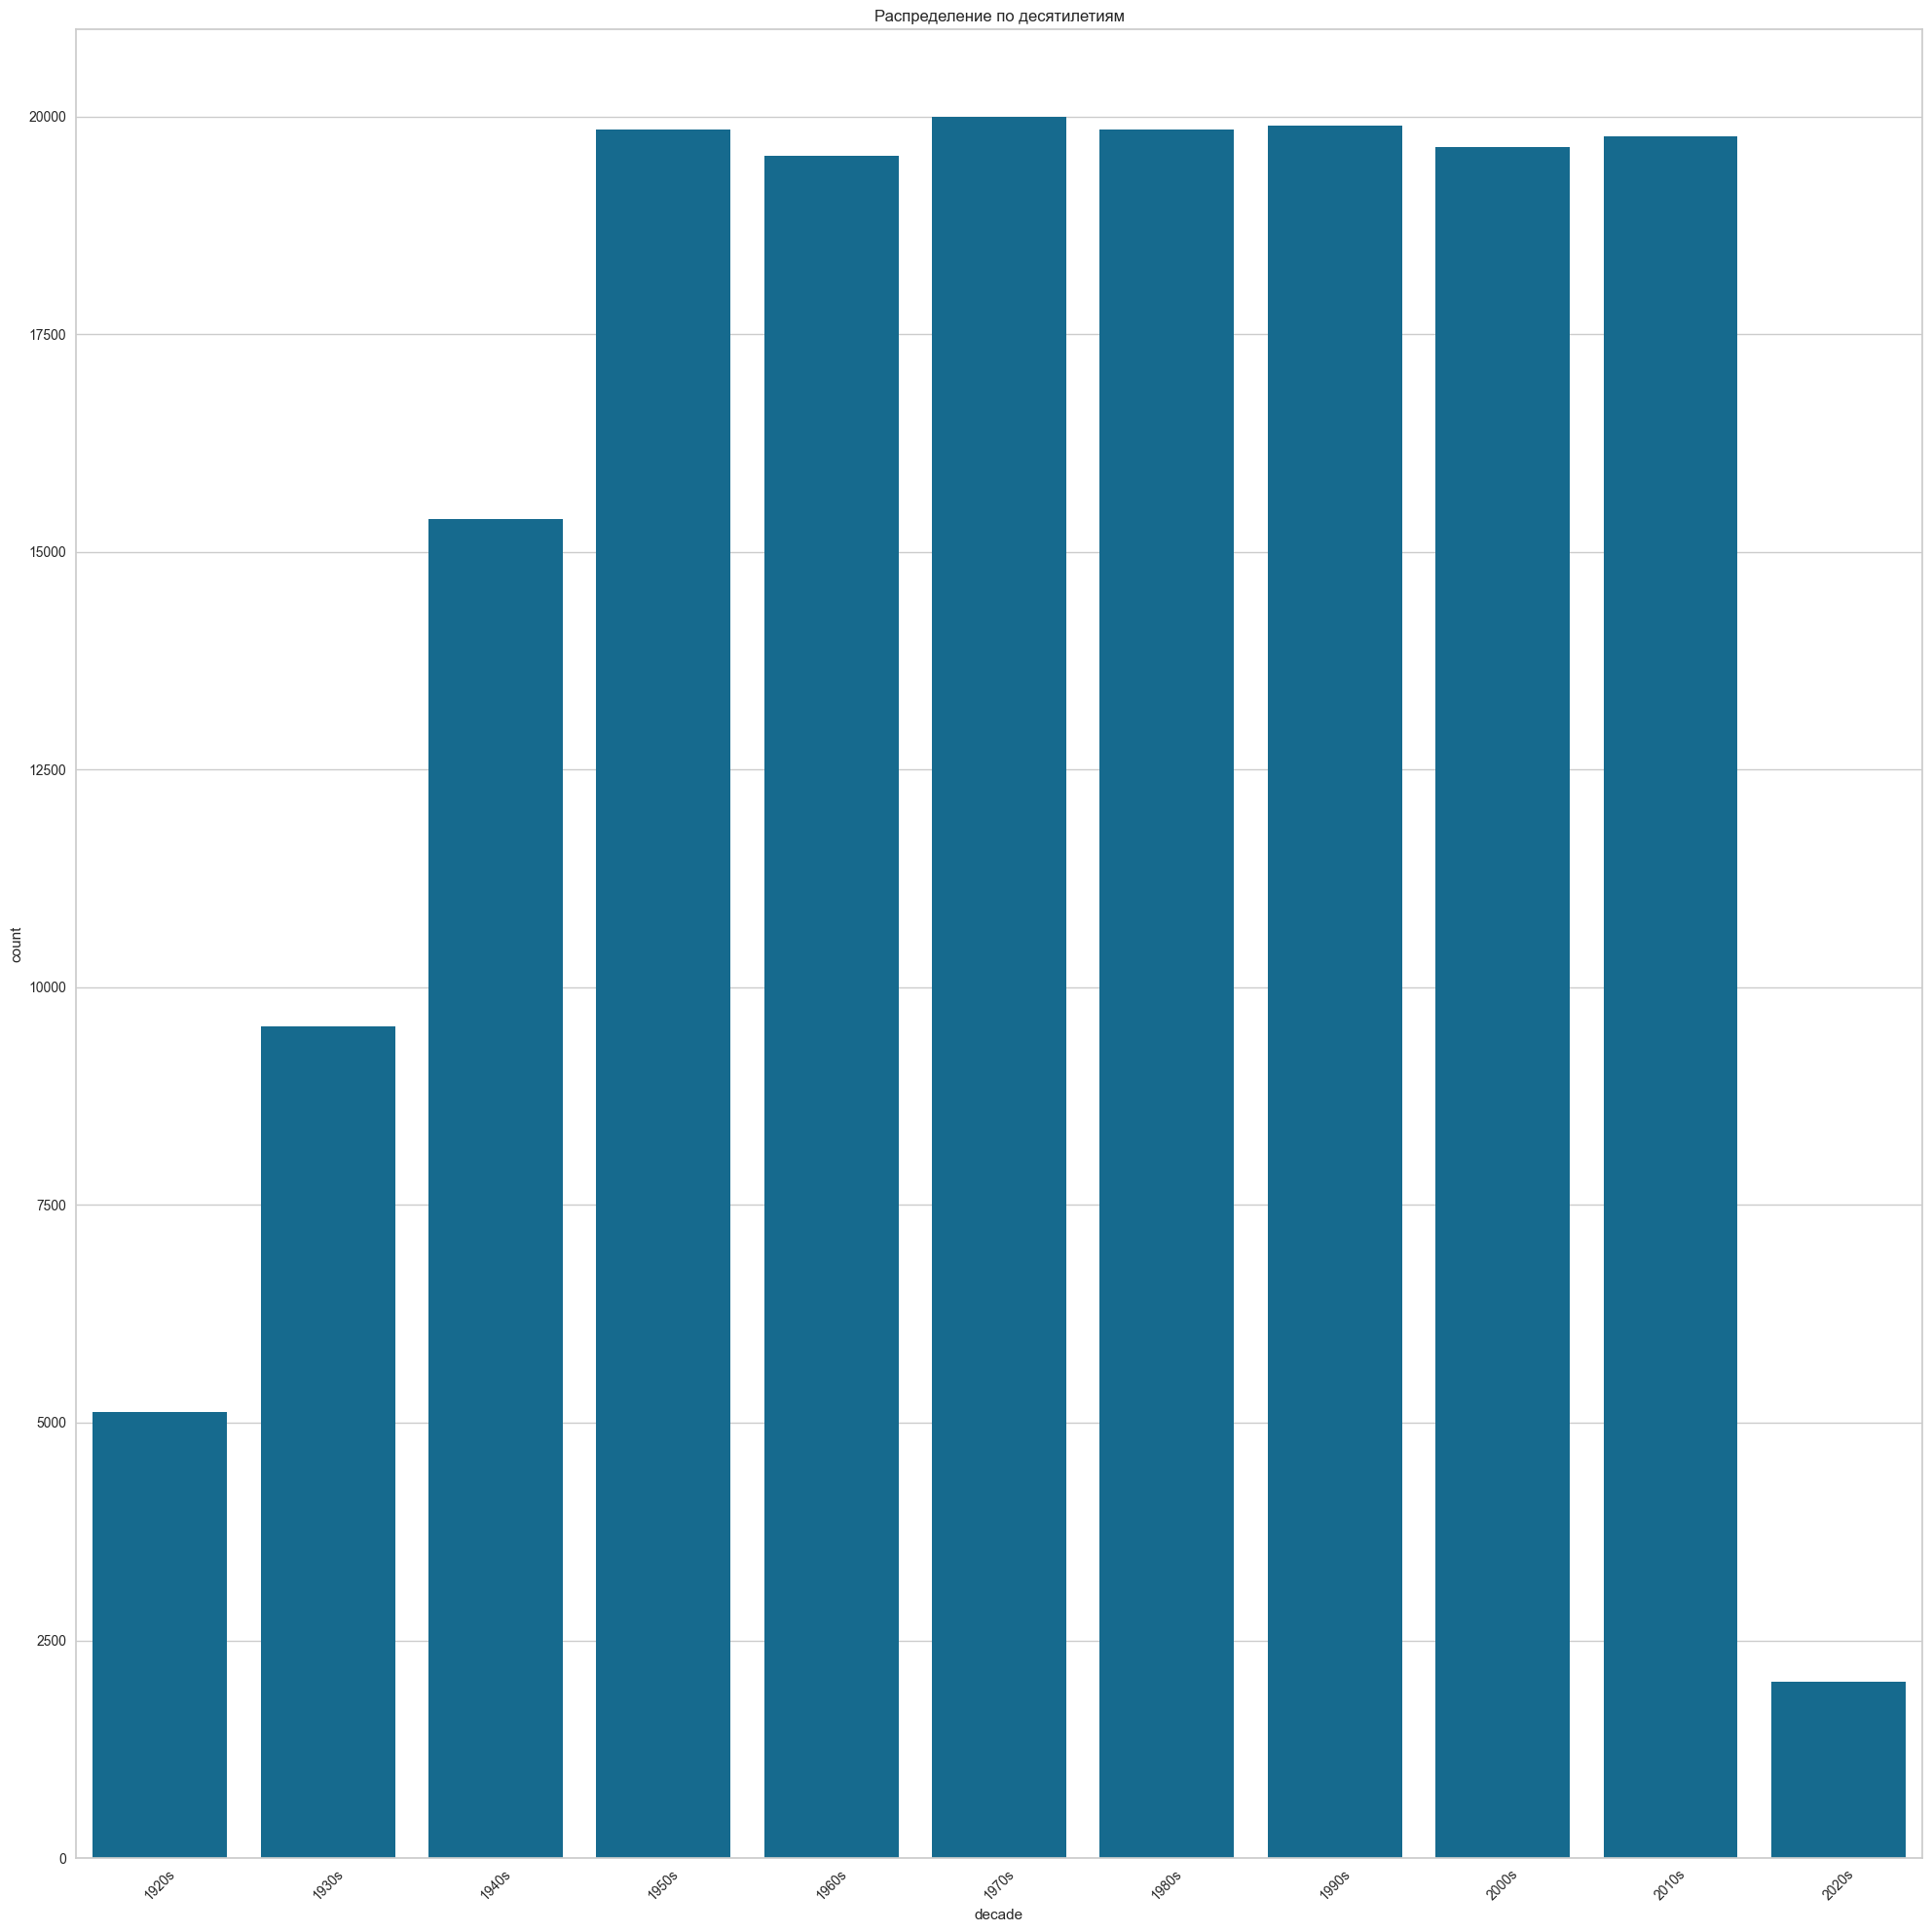

In [46]:
data['decade'] = data['year'].apply(lambda year : f'{(year//10)*10}s' )
sns.countplot(x='decade', data=data)
plt.xticks(rotation=45)
plt.title("Распределение по десятилетиям")
plt.tight_layout()
plt.show()

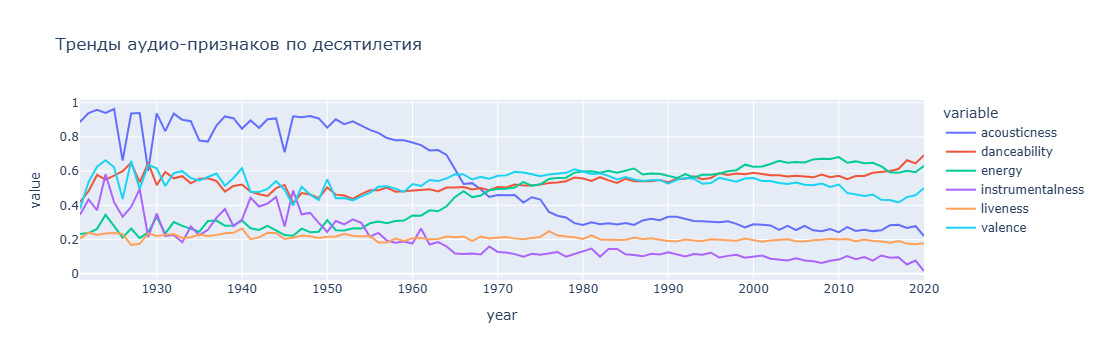

In [54]:
sound_features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'valence']
fig = px.line(year_data, x='year', y=sound_features,title='Тренды аудио-признаков по десятилетия')
fig.show()

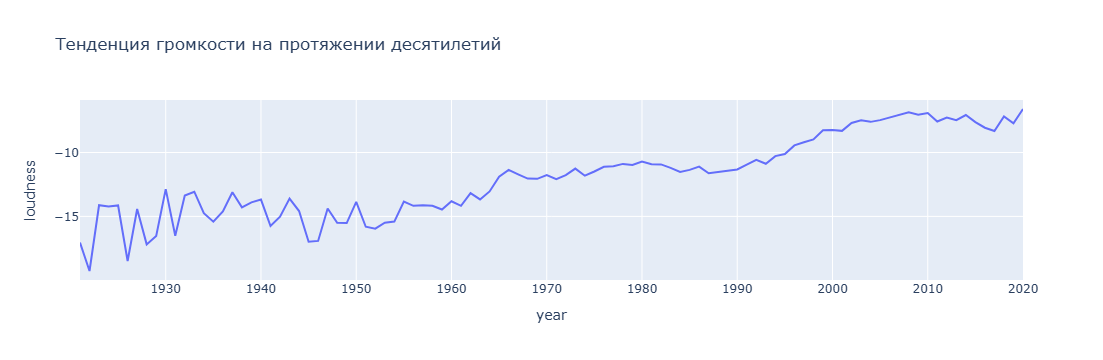

In [56]:
fig = px.line(year_data, x='year', y='loudness',title='Тенденция громкости на протяжении десятилетий')
fig.show()

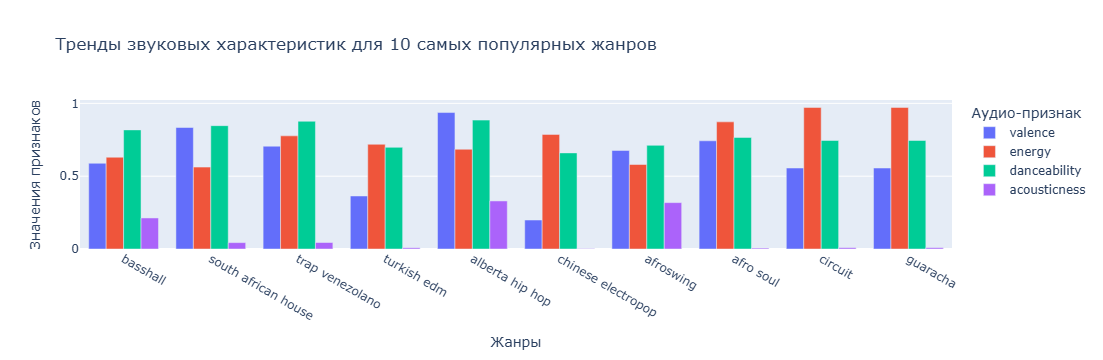

In [58]:
top10_genres = genre_data.nlargest(10, 'popularity')


fig = px.bar(
    top10_genres,
    x='genres',
    y=['valence', 'energy', 'danceability', 'acousticness'],
    barmode='group',
    title='Тренды звуковых характеристик для 10 самых популярных жанров'
)


fig.update_layout(
    xaxis_title='Жанры',
    yaxis_title='Значения признаков',
    legend_title='Аудио-признак'
)

fig.show()

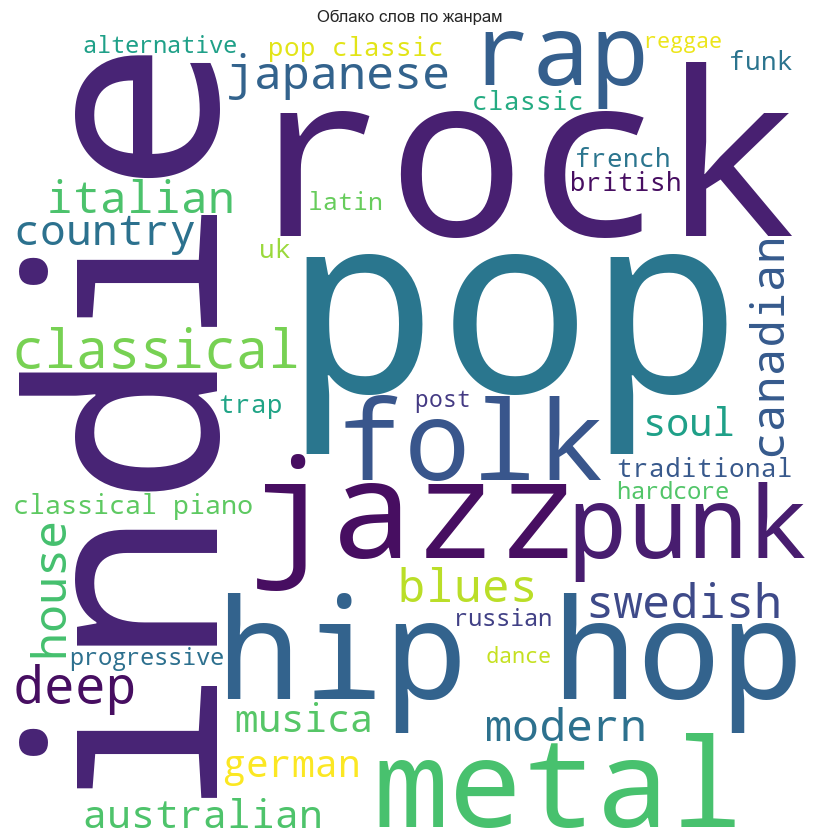

In [62]:
from wordcloud import WordCloud,STOPWORDS

stopwords = set(STOPWORDS)
comment_words = " ".join(genre_data['genres'])+" "
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                max_words=40,
                min_font_size = 10).generate(comment_words)
                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("Облако слов по жанрам")
plt.show()

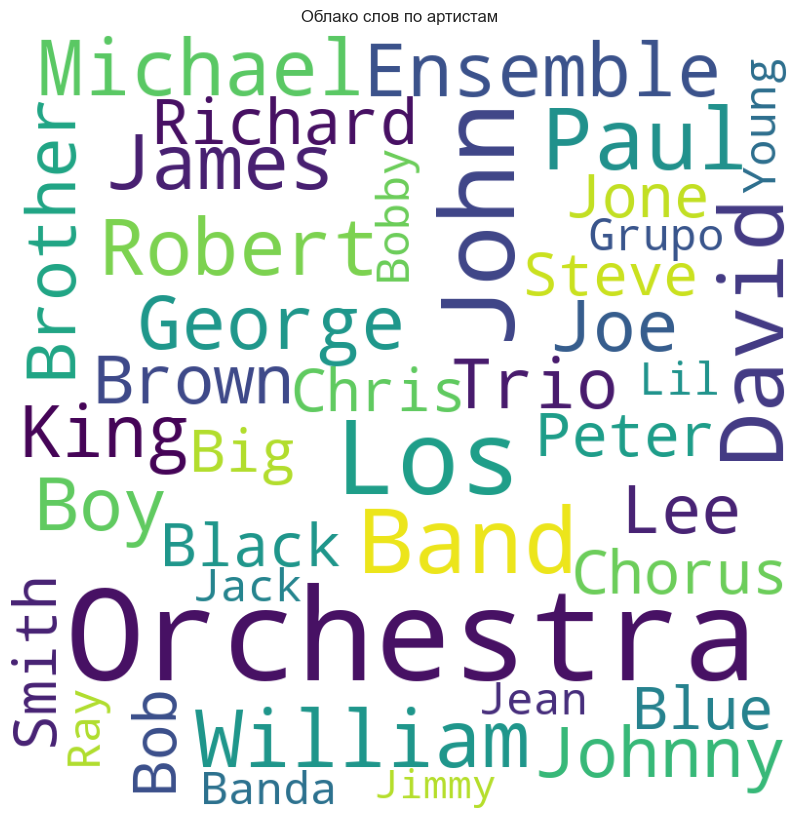

In [68]:
stopwords = set(STOPWORDS)
comment_words = " ".join(artist_data['artists'])+" "
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_word_length=3,
                max_words=40,
                min_font_size = 10).generate(comment_words)
                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Облако слов по артистам")
plt.tight_layout(pad = 0)
plt.show()

In [72]:
top10_popular_artists = artist_data.nlargest(10, 'popularity')
top10_most_song_produced_artists = artist_data.nlargest(10, 'count')

In [74]:
print('Топ-10 исполнителей, выпустивших наибольшее количество песен:')
top10_most_song_produced_artists[['count','artists']].sort_values('count', ascending=False)

Топ-10 исполнителей, выпустивших наибольшее количество песен:


count            artists
8367    3169   Francisco Canaro
28561   2422   Эрнест Хемингуэй
28560   2136  Эрих Мария Ремарк
8434    1459      Frank Sinatra
10714   1256    Ignacio Corsini
27109   1200  Vladimir Horowitz
1682    1146   Arturo Toscanini
2707    1103     Billie Holiday
12378   1061        Johnny Cash
7426    1023      Elvis Presley

In [76]:
print('Топ-10 исполнителей с наибольшим рейтингом популярности:')
top10_popular_artists[['popularity', 'artists']].sort_values('popularity', ascending=False)

Топ-10 исполнителей с наибольшим рейтингом популярности:


popularity          artists
20966        93.0      Ritt Momney
14354        92.0        Lele Pons
15070        90.0  Los Legendarios
11764        89.0         Jerry Di
7463         88.0           Emilee
23687        88.0        Surf Mesa
28263        88.0      salem ilese
213          87.0              A7S
2343         86.0          Beltito
14378        86.0     Lenny Santos

explicit
0    156220
1     14433
Name: count, dtype: int64


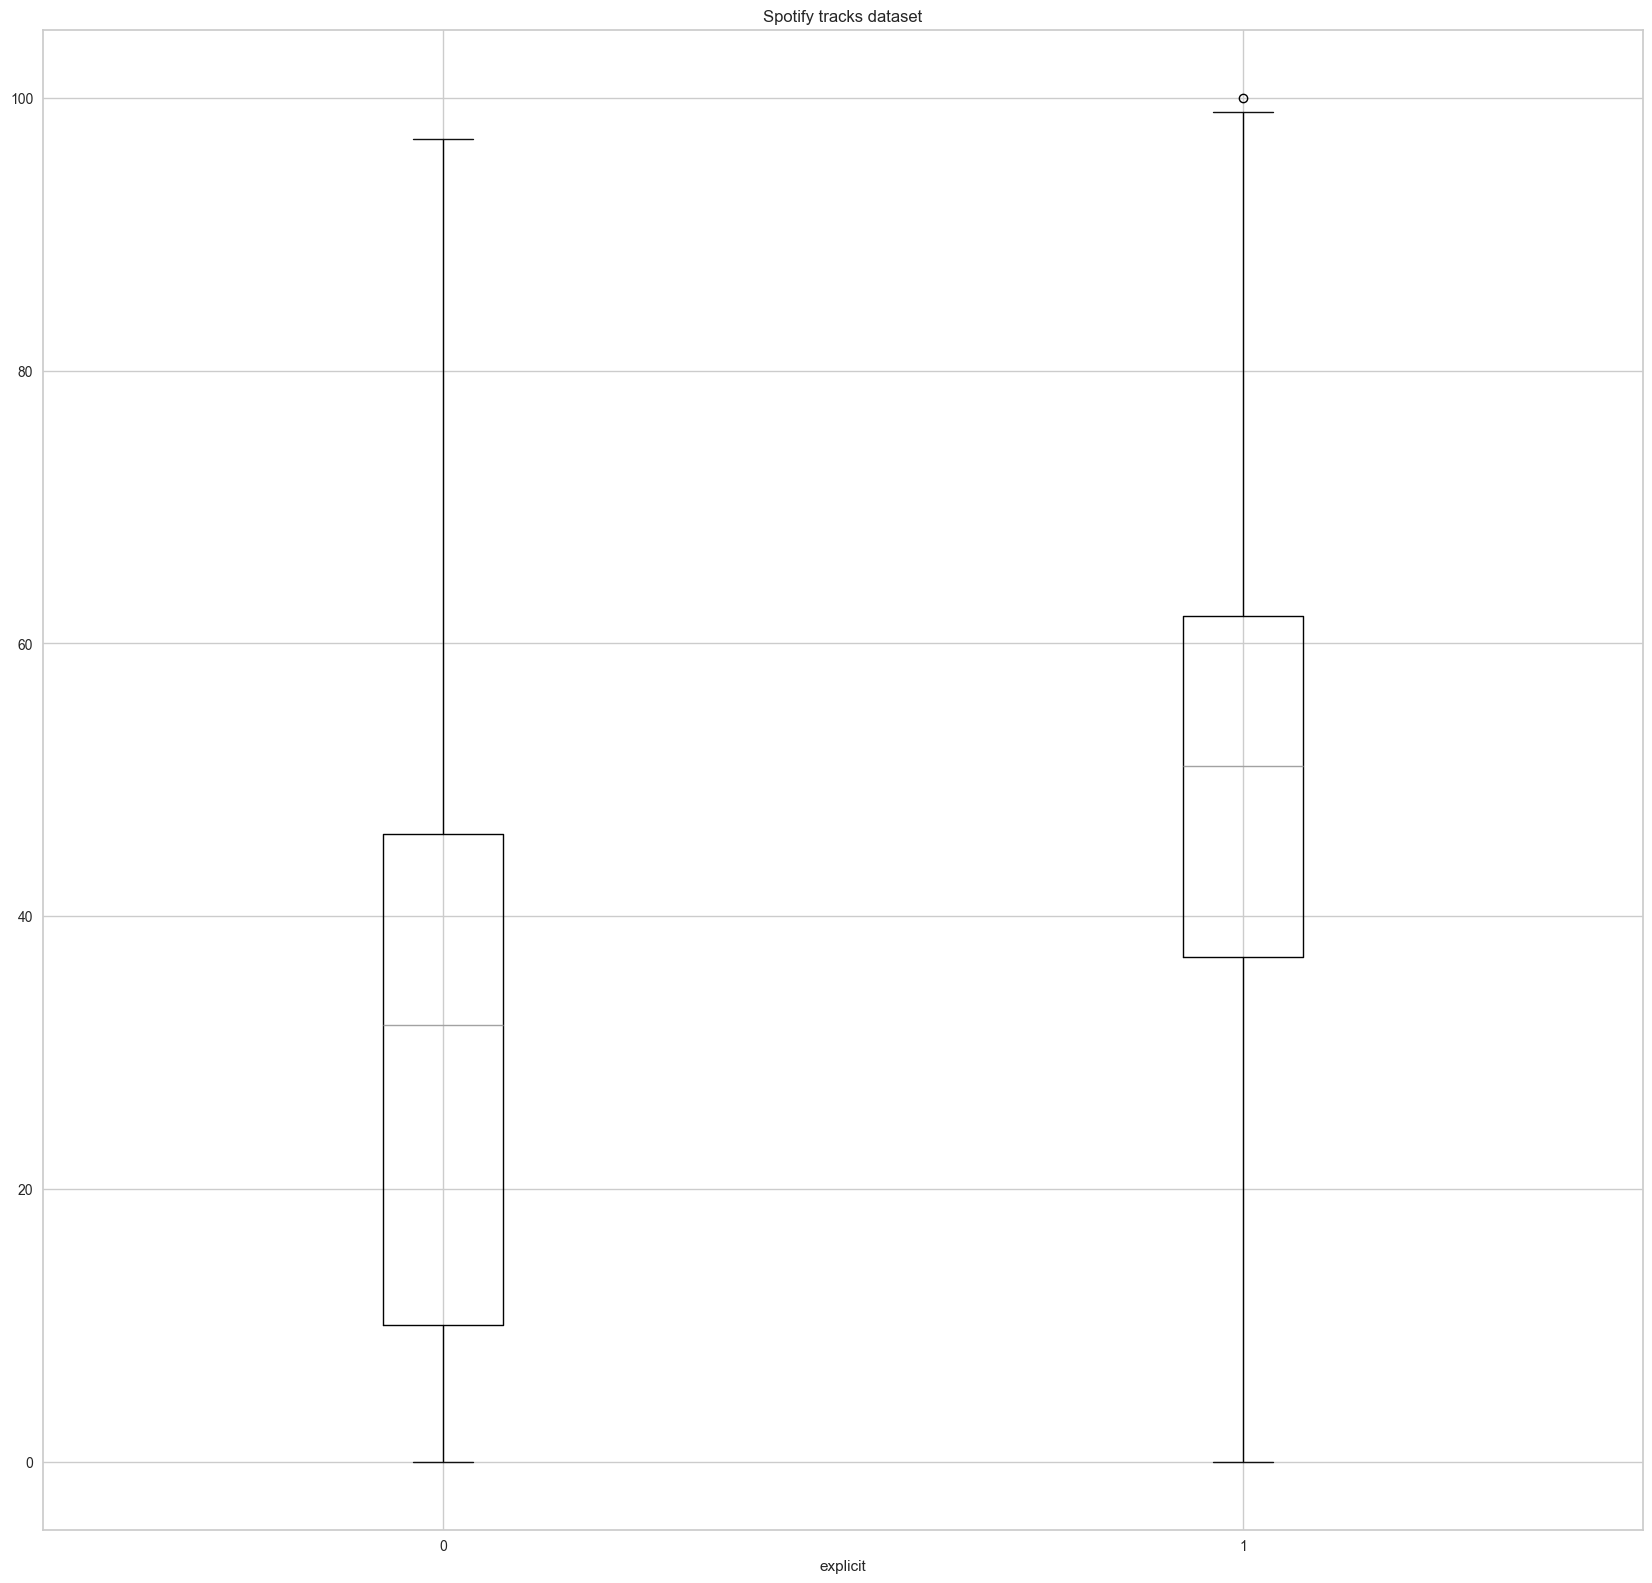

In [90]:
# значения для 'explicit'
print(data['explicit'].value_counts(dropna=False))
data.boxplot(column='popularity', by='explicit')

plt.title('Spotify tracks dataset')
plt.suptitle('') 

plt.show()

explicit
0    156220
1     14433
Name: count, dtype: int64


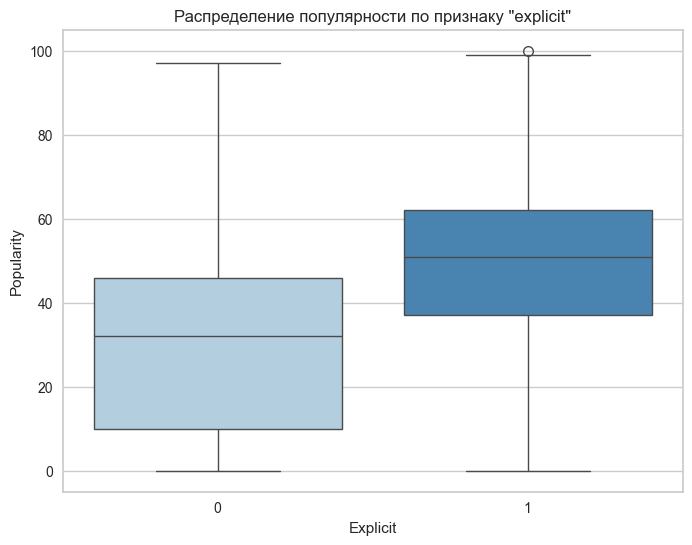

In [98]:
print(data['explicit'].value_counts(dropna=False))

plt.figure(figsize=(8, 6))
sns.boxplot(x='explicit', y='popularity', data=data, palette='Blues')

plt.title('Распределение популярности по признаку "explicit"')
plt.xlabel('Explicit')
plt.ylabel('Popularity')
plt.show()

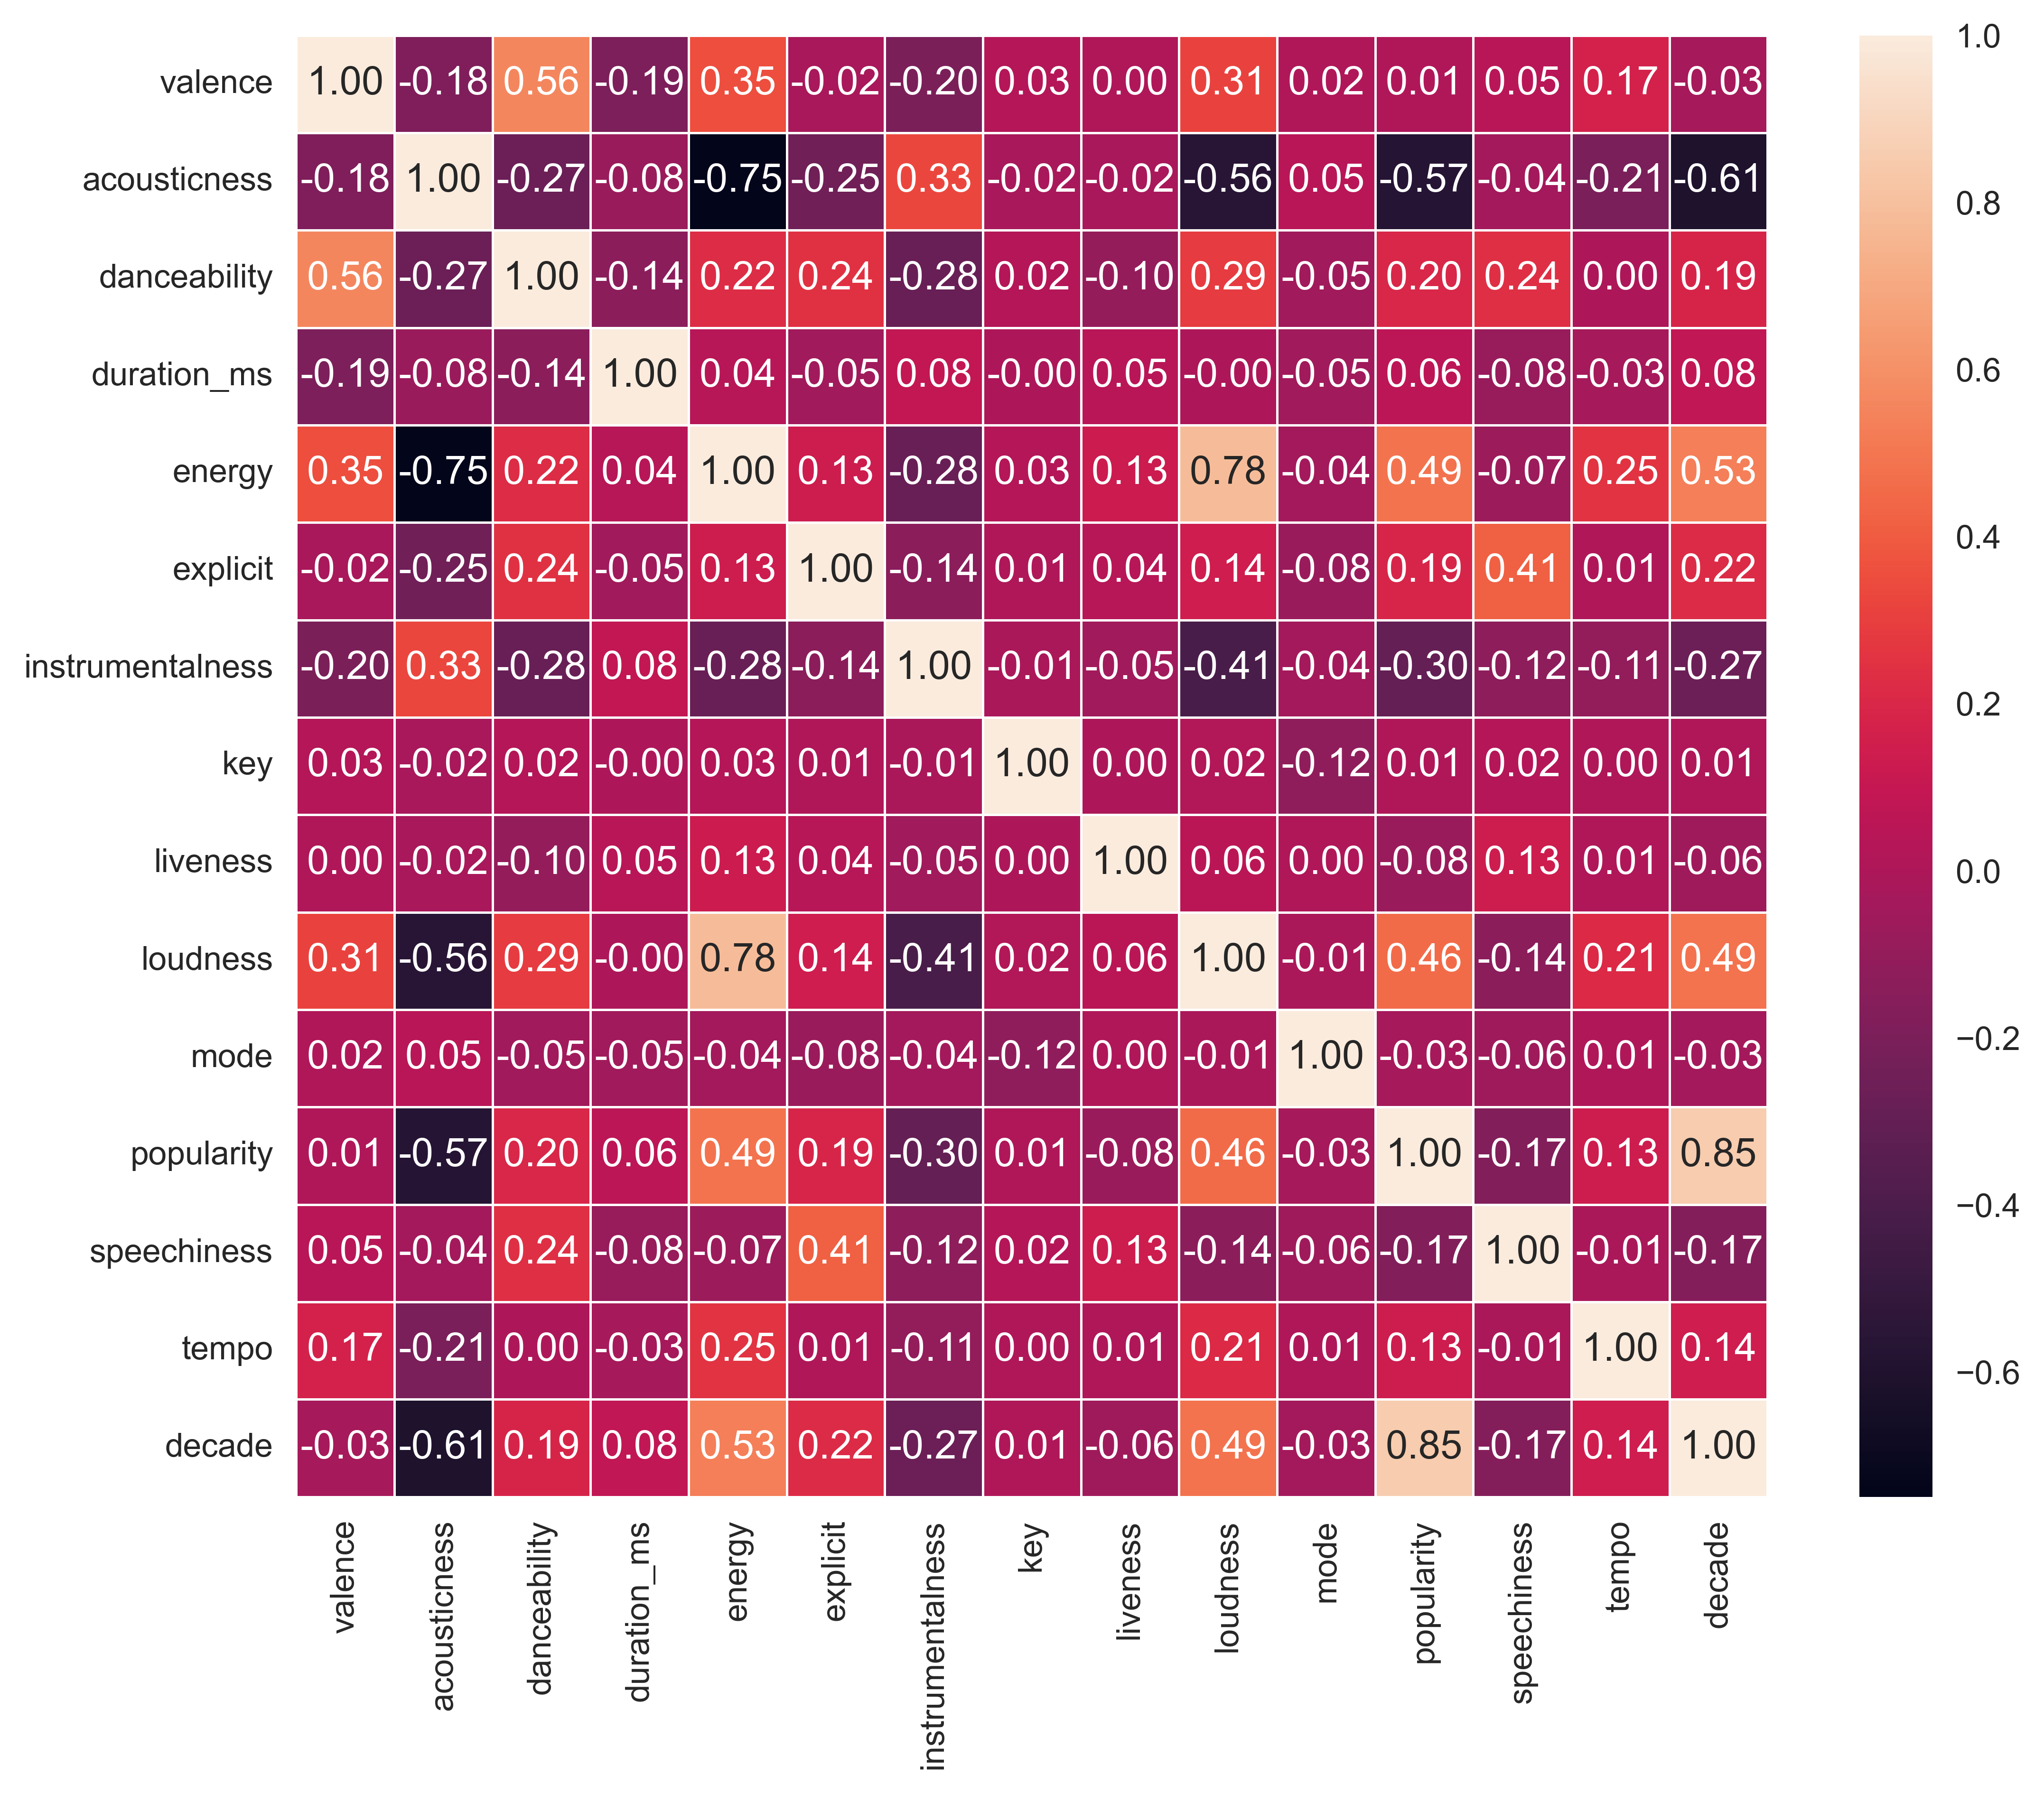

In [100]:
numerical_df = df.select_dtypes(include=['number'])
numerical_df = numerical_df.drop("year", axis=1)
corr = numerical_df.corr()
plt.figure(figsize=(10,8), dpi =500)
sns.heatmap(corr,annot=True,fmt=".2f", linewidth=.5)
plt.show()

In [ ]:
########################################################
########################################################
#Разработка рекомендательной системы (Контентная фильтрация)

In [130]:
from sklearn.preprocessing import MinMaxScaler

# грузим CSV
df = pd.read_csv("data/data.csv")

# числовые признаки
features = ['valence', 'acousticness', 'danceability', 'duration_ms', 'energy',
            'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo']

# Масштабируем
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df[features])

df_scaled = pd.DataFrame(scaled_features, columns=features)
df_scaled['name'] = df['name']
df_scaled['artists'] = df['artists']

In [140]:
from sklearn.metrics.pairwise import cosine_similarity

# рекомендации
def recommend(track_name, top_n=5):
    track_idx = df[df['name'] == track_name].index[0]
    similarities = cosine_similarity([df_scaled.loc[track_idx, features]], df_scaled[features])[0]
    top_indices = similarities.argsort()[::-1][1:top_n+1]
    return df.loc[top_indices, ['name', 'artists', 'popularity']]


print(recommend('Someday When I Stop Loving You'))

                                 name              artists  popularity
36578                  I Won't Let Go    ['Rascal Flatts']          57
14245                            Hero     ['Mariah Carey']          72
170587                    Next To You  ['Little Big Town']          65
37440   Tell Your Heart To Beat Again      ['Danny Gokey']          60
121988                       I Wonder   ['Kellie Pickler']          44


In [167]:
#KMeans
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=42)
df['cluster'] = kmeans.fit_predict(scaled_features)

def recommend_by_cluster(song_name, top_n=5):
    song_cluster = df[df['name'] == song_name]['cluster'].values[0]
    cluster_songs = df[df['cluster'] == song_cluster]
    cluster_songs = cluster_songs[cluster_songs['name'] != song_name]
    return cluster_songs.sample(min(top_n, len(cluster_songs)))[['name', 'artists', 'popularity']]

recommend_by_cluster('Someday When I Stop Loving You')

name                  artists  popularity
128816                             Fiebre   ['Los Camisas Negras']          21
20910                          Η τσακπίνα       ['Κώστας Δούσιας']           0
44115   Coventry Carol / Shepherd's Carol  ['Robert Shaw Chorale']           8
160096     The Green, Green Grass of Home          ['Dean Martin']          23
120962                               Love          ['Nancy Adams']          39

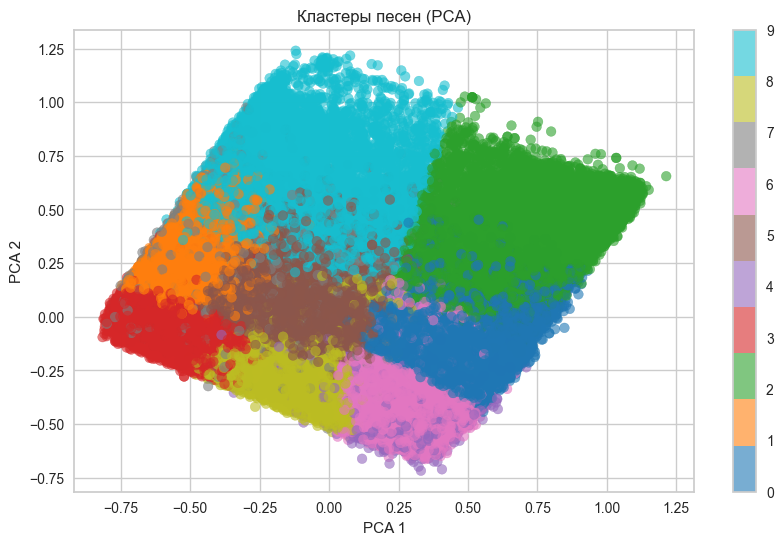

In [170]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(scaled_features)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['cluster'], cmap='tab10', alpha=0.6)
plt.title('Кластеры песен (PCA)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(scatter)
plt.show()

In [297]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestNeighbors
from collections import defaultdict

#данные
songs_df = pd.read_csv('data/data.csv')
user_prefs_df = pd.read_csv('data/group.csv')
  
# Проверка
print(songs_df.isnull().sum())
print(user_prefs_df.isnull().sum())

# фикс выбросов
def remove_outliers(df, columns, threshold=3):
    for col in columns:
        z_scores = np.abs((df[col] - df[col].mean()) / df[col].std())
        df = df[z_scores < threshold]
    return df

numeric_cols = ['valence', 'acousticness', 'danceability', 'duration_ms', 'energy', 
                'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo']
songs_df = remove_outliers(songs_df, numeric_cols)

valence             0
year                0
acousticness        0
artists             0
danceability        0
duration_ms         0
energy              0
explicit            0
id                  0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
name                0
popularity          0
release_date        0
speechiness         0
tempo               0
dtype: int64
Unnamed: 0          0
user_id             0
user_name           0
valence             0
year                0
acousticness        0
artists             0
danceability        0
duration_ms         0
energy              0
explicit            0
id                  0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
name                0
popularity          0
release_date        0
speechiness         0
tempo               0
dtype: int64


             valence   acousticness   danceability    duration_ms  \
count  157156.000000  157156.000000  157156.000000  157156.000000   
mean        0.536549       0.496263       0.540426  223693.491130   
std         0.262598       0.377079       0.173619   82322.273139   
min         0.000000       0.000000       0.056900   16416.000000   
25%         0.324000       0.094800       0.420000  172160.000000   
50%         0.548000       0.502000       0.548000  207733.000000   
75%         0.757000       0.890000       0.667000  259667.000000   
max         1.000000       0.996000       0.988000  607373.000000   

              energy  instrumentalness       liveness       loudness  \
count  157156.000000     157156.000000  157156.000000  157156.000000   
mean        0.492989          0.162384       0.184750     -10.974034   
std         0.263143          0.308880       0.133745       5.134234   
min         0.000240          0.000000       0.009670     -28.459000   
25%         0.2720

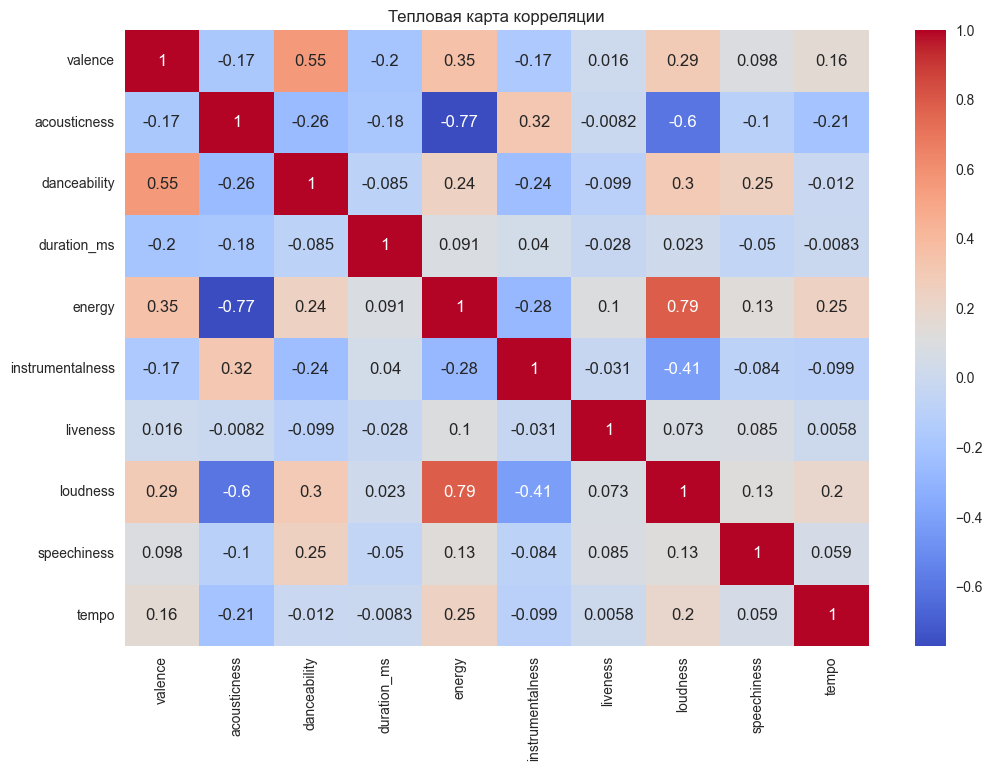

In [299]:
# статистики для числовых колонок
print(songs_df[numeric_cols].describe())

# Корреляционный анализ
corr_matrix = songs_df[numeric_cols].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Тепловая карта корреляции')
plt.show()

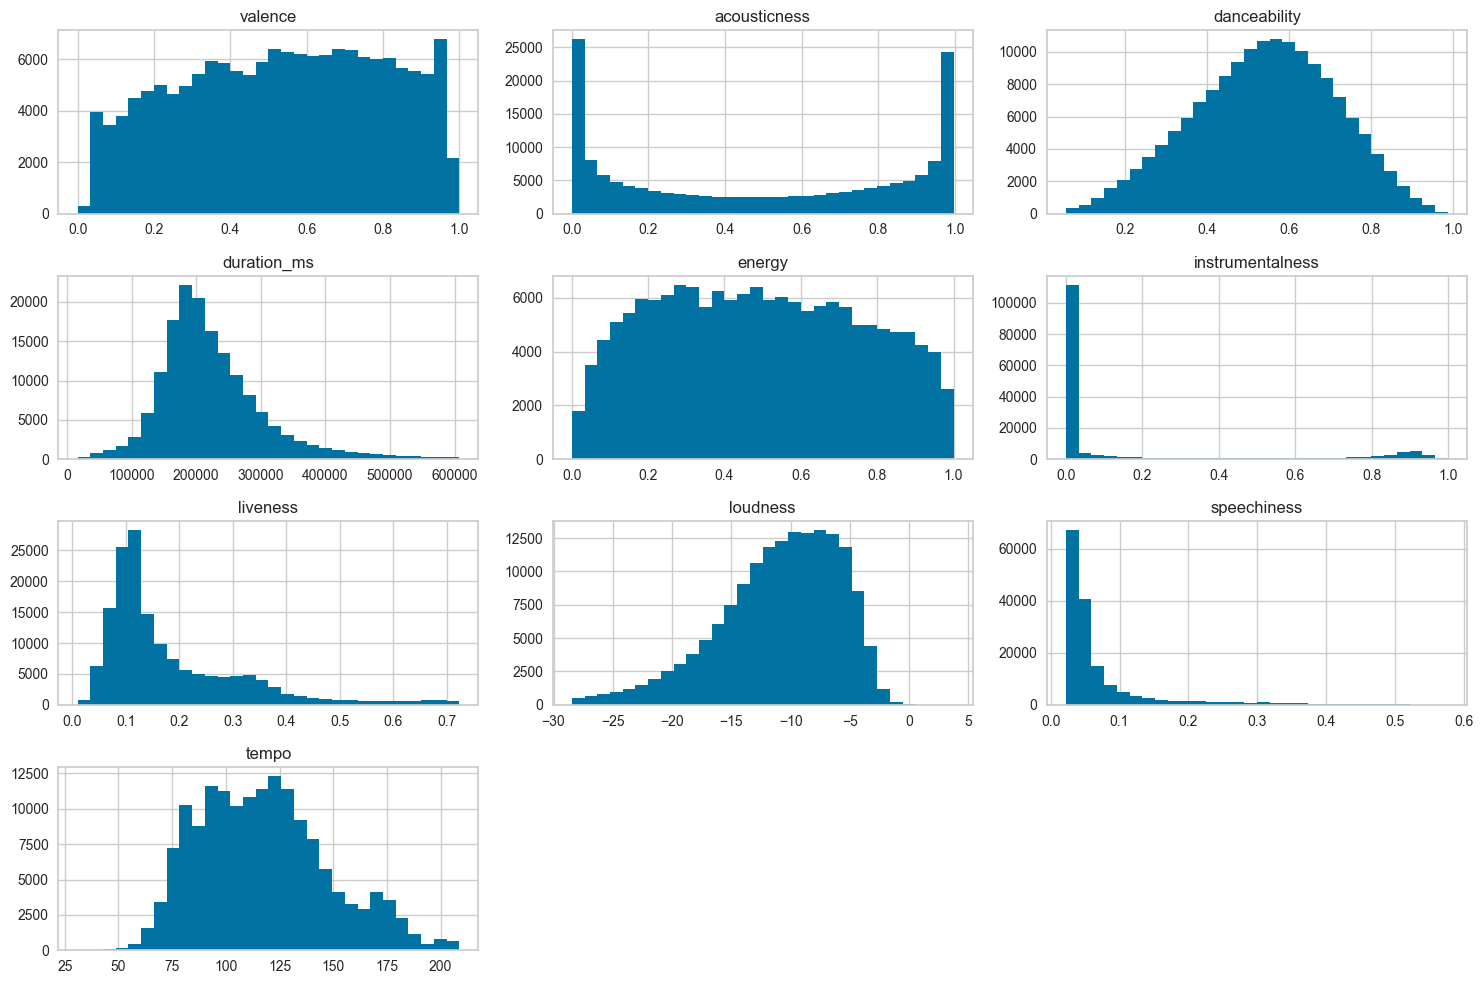

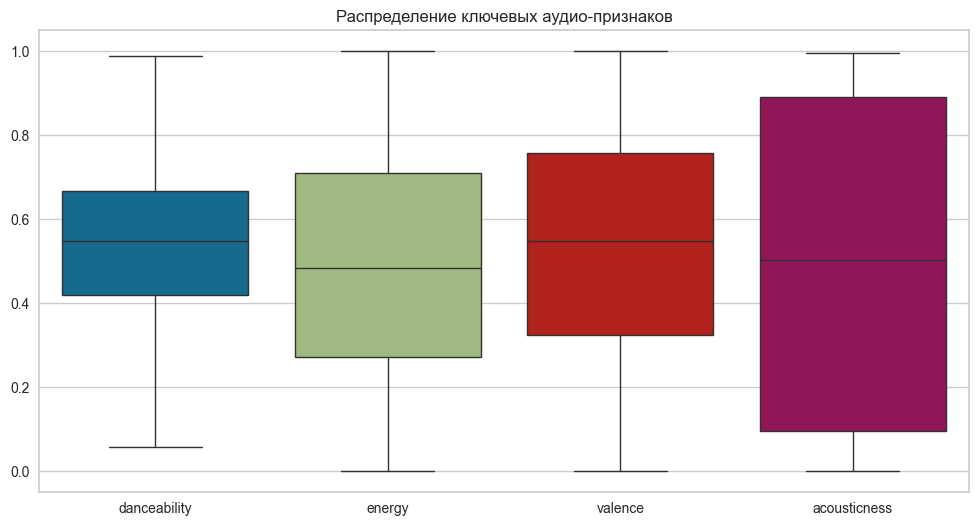

In [223]:
# Гистограммы
songs_df[numeric_cols].hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=songs_df[['danceability', 'energy', 'valence', 'acousticness']])
plt.title('Распределение ключевых аудио-признаков')
plt.show()

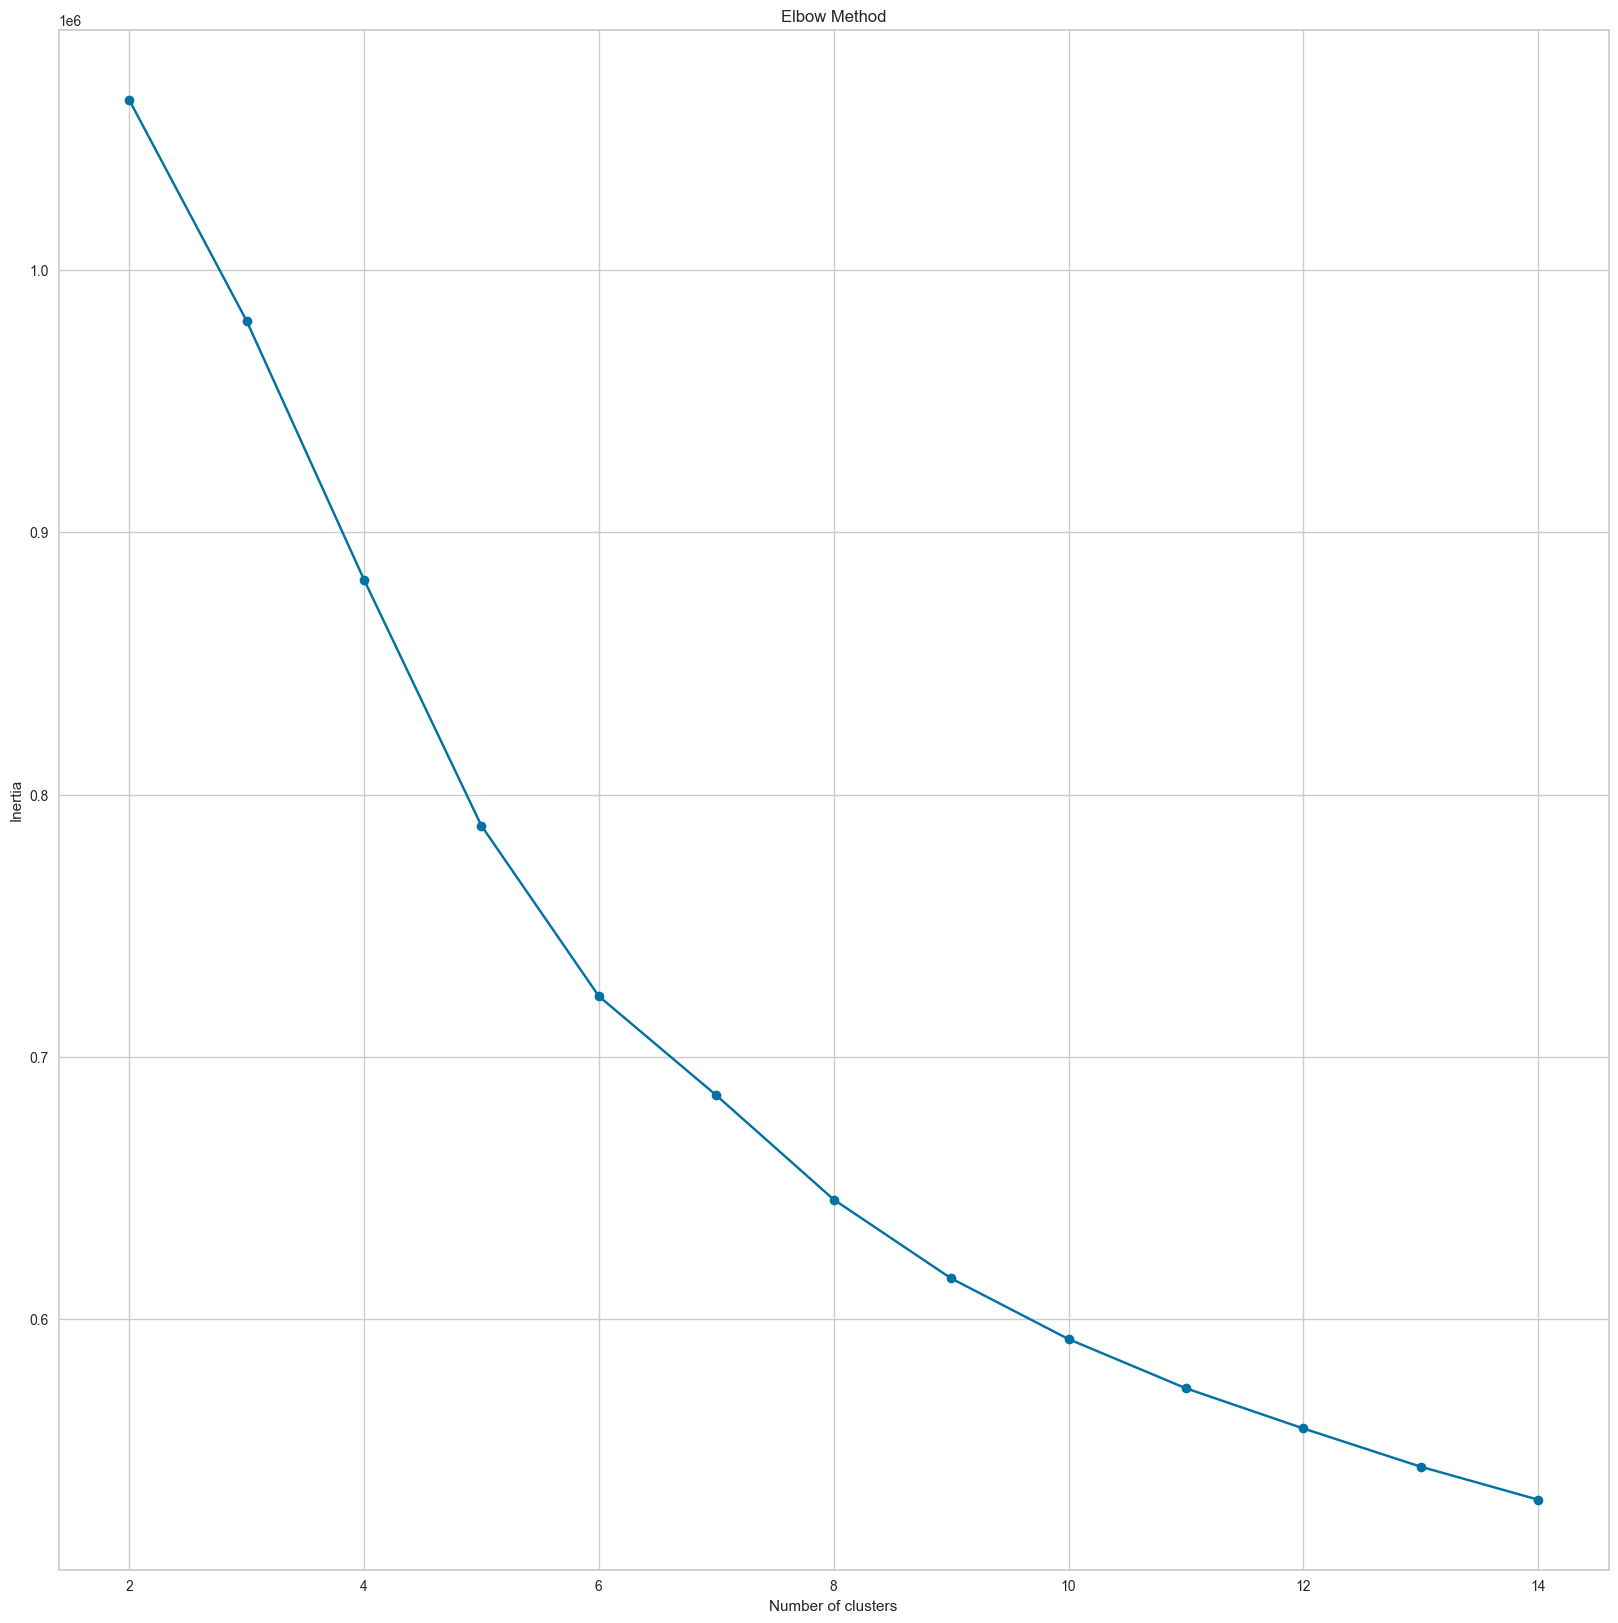

In [227]:
inertia = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(song_features)
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 15), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

# Кластеризация с оптимальным числом кластеров
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
songs_df['cluster'] = kmeans.fit_predict(song_features)

In [295]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from scipy.sparse import hstack
import warnings
warnings.filterwarnings('ignore')

def load_data(filepath):
    df = pd.read_csv(filepath, dtype={'id': str})
    df = df.dropna(how='all')
    return df


def preprocess(df):
    # Очистка artists
    df['artists'] = df['artists'].astype(str).str.replace("['", "").str.replace("']", "").str.replace("', '", ", ")
    
    num_cols = ['valence', 'acousticness', 'danceability', 'duration_ms', 'energy',
                'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo']
    
    for col in num_cols:
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '.'), errors='coerce')
    
    cat_cols = ['key', 'mode']
    for col in cat_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    df = df.dropna(subset=num_cols + cat_cols)
    return df

#  данные
data = preprocess(load_data('data/data.csv'))
validation = preprocess(load_data('data/group.csv'))

# признаки
def prepare_features(df):
    tfidf = TfidfVectorizer(max_features=50)
    text_features = tfidf.fit_transform(df['artists'] + " " + df['name'])
    
    scaler = StandardScaler()
    num_features = scaler.fit_transform(df[['valence', 'acousticness', 'danceability', 
                                          'duration_ms', 'energy', 'instrumentalness',
                                          'liveness', 'loudness', 'speechiness', 'tempo']])
    

    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
    cat_features = encoder.fit_transform(df[['key', 'mode']])
    
    return hstack([text_features, num_features, cat_features])


features = prepare_features(data)
val_features = prepare_features(validation)


svd = TruncatedSVD(n_components=50, random_state=42)
features_reduced = svd.fit_transform(features)
val_reduced = svd.transform(val_features)


kmeans = KMeans(n_clusters=100, random_state=42)
data['cluster'] = kmeans.fit_predict(features_reduced)


track_map = {track_id: idx for idx, track_id in enumerate(data['id'])}


def get_recommendations(track_id, k=5):
    if track_id not in track_map:
        return []
    
    idx = track_map[track_id]
    cluster = data.iloc[idx]['cluster']
    cluster_mask = data['cluster'] == cluster
    cluster_indices = data[cluster_mask].index
    
    target_vec = features_reduced[idx].reshape(1, -1)
    cluster_vecs = features_reduced[cluster_indices]
    
    sims = 1 - pairwise_distances(target_vec, cluster_vecs, metric='cosine')[0]
    top_k = np.argsort(sims)[-k-1:-1][::-1]
    
    return data.iloc[cluster_indices[top_k]]['id'].tolist()

# качество
def evaluate(validation_set, k_values=[5, 10, 20]):
    results = []
    
    for track_id in validation_set['id'].unique():
        
        recs = get_recommendations(track_id, max(k_values))
        
        if not recs:
            continue
        
        is_relevant = np.isin(recs, validation_set['id'].values)
        
        for k in k_values:
            tp = np.sum(is_relevant[:k])  # True positives
            precision = tp / k
            recall = tp / np.sum(validation_set['id'] == track_id)  # Обычно 1
            
            results.append({
                'k': k,
                'precision': precision,
                'recall': recall
            })
    
    return pd.DataFrame(results)


eval_results = evaluate(validation)
mean_metrics = eval_results.groupby('k').mean()

print("Средние метрики качества:")
print(mean_metrics)

print("\nИнтерпретация:")
for k in mean_metrics.index:
    prec = mean_metrics.loc[k, 'precision']
    rec = mean_metrics.loc[k, 'recall']
    print(f"При K={k}:")
    print(f"- Precision: {prec:.2%} - доля релевантных треков в рекомендациях")
    print(f"- Recall: {rec:.2%} - доля найденных релевантных треков")

# Пример рекомендаций
print("\nПример работы:")
sample_track = validation.iloc[0]
print(f"Для трека: {sample_track['name']} (ID: {sample_track['id']})")
recs = get_recommendations(sample_track['id'], 5)
print("Рекомендованные треки:")
print(data[data['id'].isin(recs)][['name', 'artists']])

Средние метрики качества:
    precision    recall
k                      
5    0.021854  0.107616
10   0.013576  0.132450
20   0.009437  0.185430

Интерпретация:
При K=5:
- Precision: 2.19% - доля релевантных треков в рекомендациях
- Recall: 10.76% - доля найденных релевантных треков
При K=10:
- Precision: 1.36% - доля релевантных треков в рекомендациях
- Recall: 13.25% - доля найденных релевантных треков
При K=20:
- Precision: 0.94% - доля релевантных треков в рекомендациях
- Recall: 18.54% - доля найденных релевантных треков

Пример работы:
Для трека: One Time (ID: 6eDApnV9Jdb1nYahOlbbUh)
Рекомендованные треки:
                                                  name  \
18058                                         Drive By   
107213                   Red - Original Demo Recording   
121296  Absolutely Not - Chanel Club Extended Mix Edit   
121846                                       Boyfriend   
169545                                            Zero   

                              

# Оценка качества рекомендательной системы

## 1. Precision@k (точность)
Показывает, какую долю рекомендованных песен оказалась релевантной (т.е. действительно понравилась пользователю).

- **При k=5**: только ~2.2% из топ-5 рекомендаций оказались действительно интересны пользователю.
- **При k=10**: точность падает до ~1.36%, потому что с увеличением количества рекомендаций возрастает "шум".
- **При k=20**: ещё ниже (~0.94%), что естественно — чем больше рекомендаций, тем ниже среднее качество каждой из них.

## 2. Recall@k (полнота)
Показывает, какую долю релевантных песен из всех возможных мы нашли в топ-k.

- **При k=5**: находим ~10.76% всех песен, которые могли бы понравиться пользователю.
- **При k=10**: уже ~13.25%.
- **При k=20**: ~18.54%, т.е. больше охват, но ценой уменьшения точности.

## Выводы

Precision и recall — это компромисс:
- При увеличении **k**:
  - Увеличивается **recall** (находим больше релевантных треков)
  - Уменьшается **precision** (больше нерелевантных рекомендаций)

**Текущие показатели** говорят о слабом качестве модели:
- 2% точности ≈ 1 релевантный трек из 50, что довольно мало.